In [434]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
random.seed(10)


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5.0,5,0.25)
ys = f(xs)

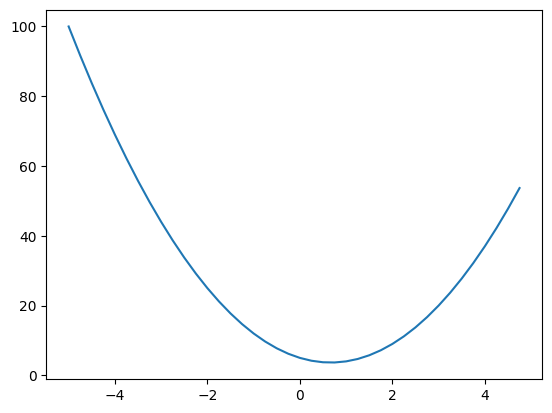

In [5]:
plt.plot(xs,ys)

In [6]:
h = 0.0001
# Multi variable calculus
a =7.0
b = -3.0
c = 12.0

d1 = a*b +c
c += h
d2 = a*b +c

print('d1:',d1)
print('d2:',d2)
print("slope",round((d2-d1)/h,4))


d1: -9.0
d2: -8.9999
slope 1.0


In [7]:
from graphviz import Digraph
def trace(item):
    nodus,edjus = list(),list()
    def build(inputaa):
        if inputaa not in nodus:
            nodus.append(inputaa)
            for child in inputaa._prev:
                edjus.append((child,inputaa))
                build(child)
    build(item)
    return nodus,edjus

def drawdot(root):
    dot = Digraph(format='png',graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(name = uid,label = "{%s|val = %.4f |grad = %.4f }" % (node.label,node.data,node.grad),shape ='record')
        if node._op:
            dot.node(name= uid+node._op, label = node._op)
            dot.edge(uid+node._op,uid)
            for predi in node._prev:
                dot.edge(str(id(predi)),uid+node._op,)
    return dot    

In [8]:
class Value:
    def __init__(self,data,_prev =(),_op = '',label = ''):
        self.data = data
        self._prev = _prev
        self._op = _op
        self._backward = lambda:None 
        self.grad = 0.0
        self.label = label

    def __repr__(self):
#         print('repr ran')
        return f' value = {self.data}'
    def __add__(self,father):
        father = father if isinstance(father,Value) else Value(father)
        out = Value(self.data +father.data,(self,father),'+')
        
        def _backward():
            parents = out._prev
            parents[0].grad += out.grad
            parents[1].grad += out.grad
        out._backward = _backward
        return out
    def __sub__(self,other):
        return self+(-other)
    
    def __radd__(khud,mother):
        return khud+mother
    def __rsub__(khud,mother):
        return khud-mother
    def __mul__(khud,mother):
        mother = mother if isinstance(mother,Value) else Value(mother)
        out = Value(khud.data * mother.data,(khud,mother),"*")
        def _backward():
            parents = out._prev
            parents[0].grad += parents[1].data*out.grad
            parents[1].grad += parents[0].data*out.grad
            
        out._backward = _backward
        return out
    def __rmul__(khud,mother):
        return khud*mother
    def __truediv__(self,other):
        return self*other**-1
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),"**")
        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        def _backward():
            parents = out._prev
            parents[0].grad += (1-out.data**2)*out.grad
        x= self.data
        out = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(out,(self,),_op = 'tanh')
        out._backward = _backward
        return out
    def exp(self):
        out = Value(math.exp(self.data),_prev=(self,),_op="exp")
        def _backward():
            self.grad += out.data * out.grad
        self._backward = _backward
        return out
    def backward(self):
        self.grad = 1.0
        nodes ,_ = trace(self)
        for x in nodes:
            x._backward() 

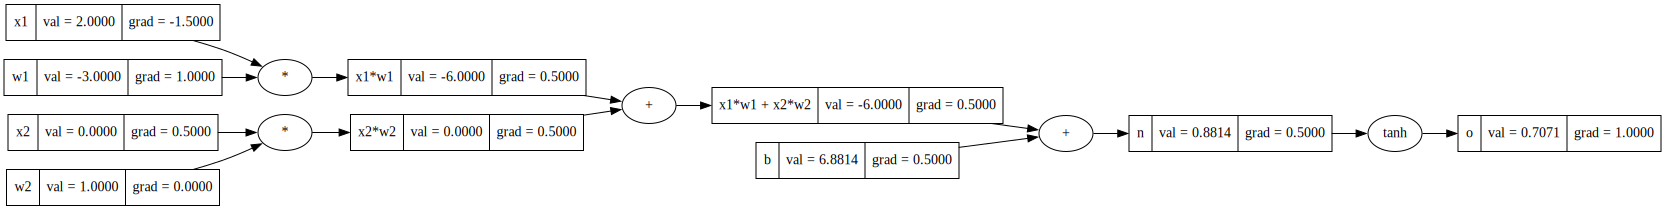

In [9]:
# input x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.88137,label = 'b')
## x1w1 + x2w2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label='n'
o = n.tanh(); o.label = 'o'
# _____________________________________
# e = (2*n).exp()
# o = (e+1)/(e-1)
# _____________________________________

o.backward()
drawdot(o)

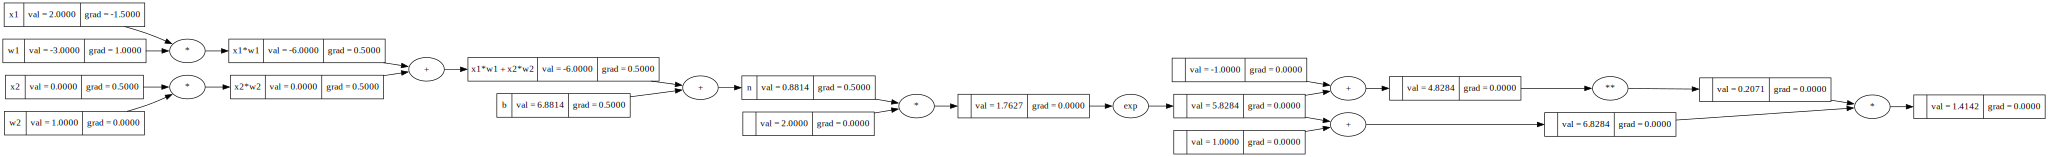

In [10]:
e = (2*n).exp()
o = (e+1)/(e-1)
drawdot(o)

In [438]:
class Neuron:
    def __init__(self,ronsin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(ronsin) ]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        activals = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = activals.tanh()
        ### returns a variable which has sum of all inputs
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,rosins,noutputs):
        self.neurons = [Neuron(rosins) for _ in range(noutputs)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        ### list of variable matching with each neuron
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self,ninput,nlayers):
        sz = [ninput]+nlayers
        self.layers = [Layer(sz[i],sz[i+1]) for i in range (len(nlayers))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
            ### passing each previous layer's output neurons as input to next neuron layer
        return x
    def parameters(self):
        return [p for layer in self.layers for p  in layer.parameters()]
x = [2.0,3.0,4.0]
n = MLP(3,[4,4,1])
n(x)
        

 value = -0.7490243609061698

In [436]:
### basic Binary classifier Neural Net
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0]
      ,[1.0,1.0,-1.0]]
ys = [1.0,-1.0,1.0,-1.0] #

In [429]:

loss = sum((yreq-ypred)**2 for yreq,ypred in zip(ys,ypred))
loss.backward()
loss
# drawdot(loss)

 value = 0.04788568538355067

In [439]:

for x in range(110):
    #forward 
    ypred =[n(x) for x in xs]   
    ###Mean sqaured error loss function
    loss = sum((yreq-ypred)**2 for yreq,ypred in zip(ys,ypred))

    #backward
    loss.backward()
    #update
    for p in n.parameters():
        p.data += -0.01*p.grad
        p.grad = 0.0
    print(x,loss.data)
    

0 5.843694144272712
1 5.606086723510244
2 5.344534915914197
3 5.065490866014423
4 4.780015727727991
5 4.502377647664737
6 4.246527327873297
7 4.022044098705735
8 3.832042542232638
9 3.6740040502142075
10 3.5422678840308346
11 3.4304019975113507
12 3.3326238657484017
13 3.2443427999555468
14 3.162187175366615
15 3.0838151064663126
16 3.0076740225960807
17 2.932780409061233
18 2.8585420811658975
19 2.784624402114225
20 2.7108544961535848
21 2.637155818238723
22 2.563505799226107
23 2.489910267754559
24 2.4163894751451025
25 2.3429716655090718
26 2.269691170345799
27 2.1965889110078756
28 2.123713924260125
29 2.051125072283736
30 1.9788924726214552
31 1.907098418239289
32 1.8358376924934978
33 1.765217254936327
34 1.695355310178384
35 1.6263797928887764
36 1.558426318902193
37 1.4916356707481215
38 1.426150907008649
39 1.36211420733961
40 1.2996635857521754
41 1.2389296201698834
42 1.1800323528482908
43 1.123078511428072
44 1.0681591832136719
45 1.0153480466343916
46 0.9647002264620119
47